### Tensorflow time series forecasting applied to driving cycle data
Reference: https://www.tensorflow.org/tutorials/structured_data/time_series

In [844]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

### Driving cycle dataset

In [845]:
df = pd.read_csv('data/nedc.csv', names=['t (s)', 'v (km/h)'], index_col='t (s)')
df

,v (km/h)
t (s),
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
1176,0.0
1177,0.0
1178,0.0


<AxesSubplot:xlabel='t (s)'>

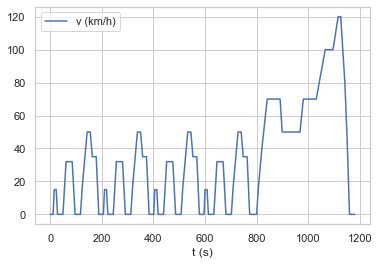

In [846]:
df.plot()

### Have it repeated

In [847]:
df = pd.concat([df, df[1:]], ignore_index=True)
df

,v (km/h)
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2356,0.0
2357,0.0
2358,0.0
2359,0.0


<AxesSubplot:xlabel='t (s)'>

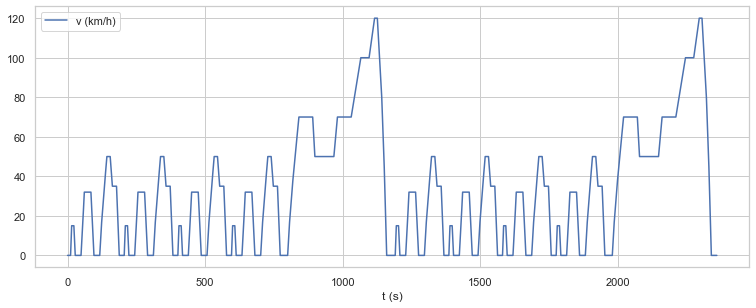

In [848]:
df.index.name = 't (s)'
df.plot(figsize=(12.8, 4.8))

In [849]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
v (km/h),2361.0,33.612876,30.985363,0.0,2.5,32.0,50.0,120.0


### Training/Validation/Test = (70%, 20%, 10%)

In [850]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices

{'v (km/h)': 0}

In [851]:
n = len(df)
train_df = df[0:int(n * 0.7)]
val_df = df[int(n * 0.7):int(n * 0.9)]
test_df = df[int(n * 0.9):]

num_features = df.shape[1] # 1

### Normalize the data

In [852]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [853]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
df_std

,Column,Normalized
0,v (km/h),-1.016863
1,v (km/h),-1.016863
2,v (km/h),-1.016863
3,v (km/h),-1.016863
4,v (km/h),-1.016863
...,...,...
2356,v (km/h),-1.016863
2357,v (km/h),-1.016863
2358,v (km/h),-1.016863
2359,v (km/h),-1.016863


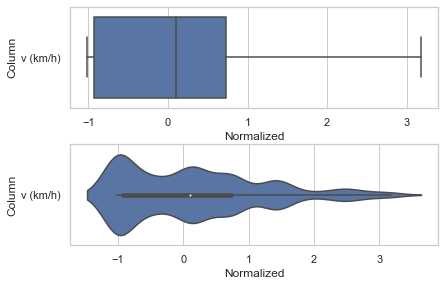

In [854]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(nrows=2)
fig.tight_layout()
ax = sns.boxplot(x='Normalized', y='Column', data=df_std, ax=axes[0])
ax = sns.violinplot(x='Normalized', y='Column', data=df_std, ax=axes[1])

plt.show()

### Data windowing

#### 1. Indexes and offsets

In [855]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

**Single prediction 24t into the future, given 24t of history**

In [856]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['v (km/h)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['v (km/h)']

**Single prediction 1t into the future, given 6t of history**

In [857]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['v (km/h)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['v (km/h)']

#### 2. Split into inputs/labels

In [858]:
def split_window(self, features):
    # [batch_size, window_size, features]
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.label_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

# Stack three slices by the length of the total window
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                          np.array(train_df[10:10 + w2.total_window_size]),
                          np.array(train_df[20:20 + w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


6-timestep & 1-feature inputs to 1-timestep & 1-feature label<br>
**(Now only the variable is the velocity itself)**

#### 3. Plot

In [859]:
w2.example = example_inputs, example_labels

In [860]:
def plot(self, model=None, plot_col='v (km/h)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col] # Here we have only one input column.
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n + 1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
            
        if label_col_index is None:
            continue
            
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                   edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)
            
        if n == 0:
            plt.legend()
                  
    plt.xlabel('Time [s]')

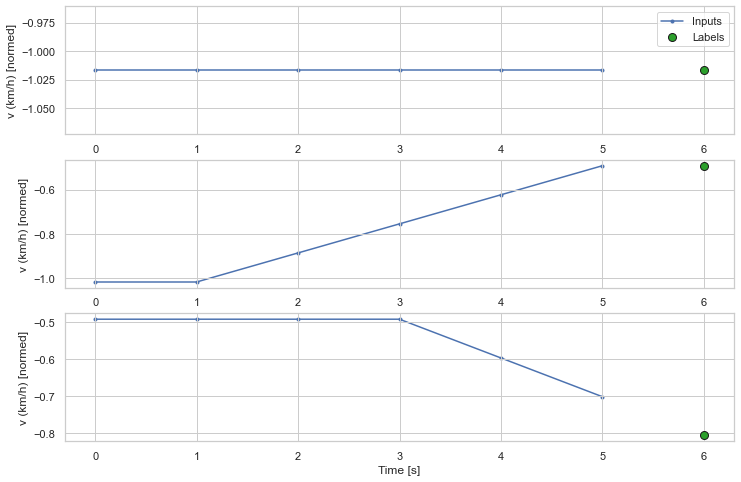

In [861]:
WindowGenerator.plot = plot
w2.plot()

#### 4. Create tf.data.Dataset <br>
Convert pandas.DataFrame to tensorflow.data.Dataset

In [862]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32)
    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.test))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

w2.train.element_spec

Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['v (km/h)']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['v (km/h)']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [863]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


### Single step models <br>
Simplest model

In [864]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['v (km/h)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['v (km/h)']

In [865]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


#### Baseline <br>
Return the current value as the prediction (i.e., predicting "no change")

In [866]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]
    
baseline = Baseline(label_index=column_indices['v (km/h)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - 0s 500us/step - loss: 0.0028 - mean_absolute_error: 0.0282


In [867]:
wide_window = WindowGenerator(
    input_width=32, label_width=32, shift=1,
    label_columns=['v (km/h)'])

wide_window

Total window size: 33
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Label column name(s): ['v (km/h)']

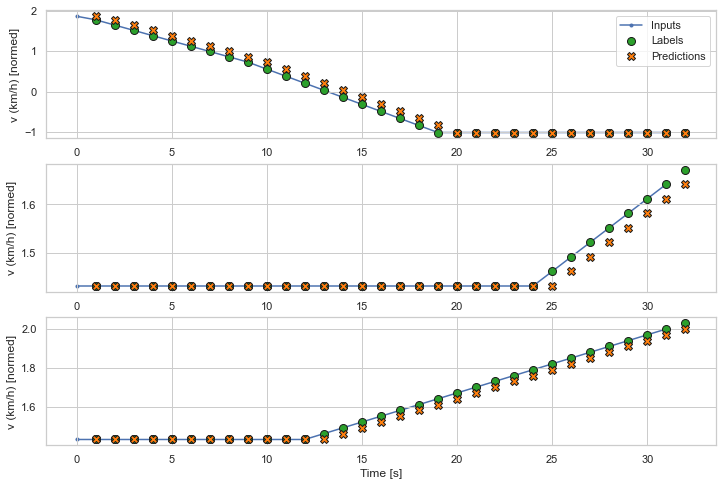

In [869]:
wide_window.plot(baseline)

#### Linear model <br>
layers.Dense with no activation set

In [870]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 1)
Output shape: (32, 1, 1)


In [871]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    
    return history

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test)

Epoch 1/20
52/52 [==============================] - 0s 3ms/step - loss: 1.8672 - mean_absolute_error: 1.0903 - val_loss: 1.2465 - val_mean_absolute_error: 0.9702
Epoch 2/20
52/52 [==============================] - 0s 1ms/step - loss: 1.7349 - mean_absolute_error: 1.0512 - val_loss: 1.1570 - val_mean_absolute_error: 0.9347
Epoch 3/20
52/52 [==============================] - 0s 1ms/step - loss: 1.6098 - mean_absolute_error: 1.0124 - val_loss: 1.0724 - val_mean_absolute_error: 0.8999
Epoch 4/20
52/52 [==============================] - 0s 1ms/step - loss: 1.4914 - mean_absolute_error: 0.9745 - val_loss: 0.9925 - val_mean_absolute_error: 0.8657
Epoch 5/20
52/52 [==============================] - 0s 1ms/step - loss: 1.3792 - mean_absolute_error: 0.9371 - val_loss: 0.9172 - val_mean_absolute_error: 0.8323
Epoch 6/20
52/52 [==============================] - 0s 1ms/step - loss: 1.2734 - mean_absolute_error: 0.9004 - val_loss: 0.8467 - val_mean_absolute_error: 0.7997
Epoch 7/20
52/52 [==========

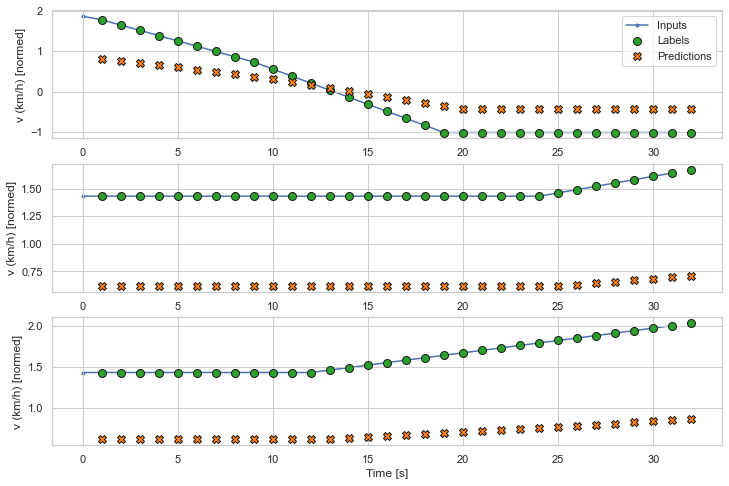

In [872]:
wide_window.plot(linear)

#### Dense <br>

In [873]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

Epoch 1/20
52/52 [==============================] - 0s 3ms/step - loss: 0.3061 - mean_absolute_error: 0.3267 - val_loss: 0.0088 - val_mean_absolute_error: 0.0794
Epoch 2/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0072 - mean_absolute_error: 0.0648 - val_loss: 0.0035 - val_mean_absolute_error: 0.0431
Epoch 3/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_absolute_error: 0.0424 - val_loss: 0.0029 - val_mean_absolute_error: 0.0343
Epoch 4/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_absolute_error: 0.0375 - val_loss: 0.0028 - val_mean_absolute_error: 0.0338
Epoch 5/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_absolute_error: 0.0369 - val_loss: 0.0028 - val_mean_absolute_error: 0.0329
Epoch 6/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_absolute_error: 0.0375 - val_loss: 0.0029 - val_mean_absolute_error: 0.0369
Epoch 7/20
8/8 [============

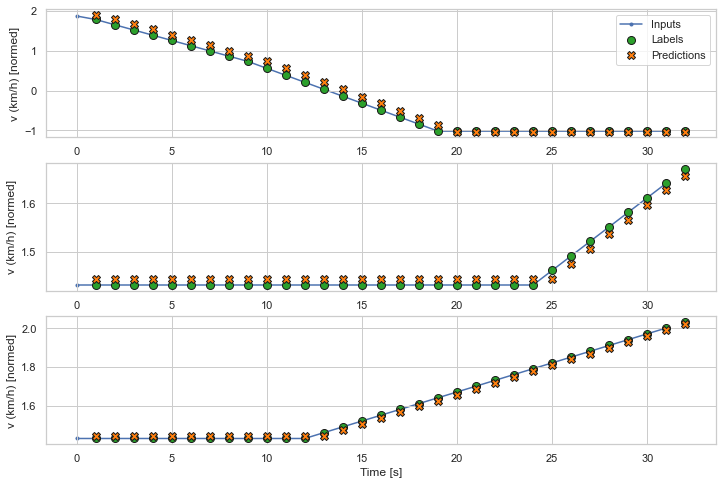

In [874]:
wide_window.plot(dense)

#### Multi-step dense <br>
Given multiple time steps as input, predict one time step into the future

In [876]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['v (km/h)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['v (km/h)']

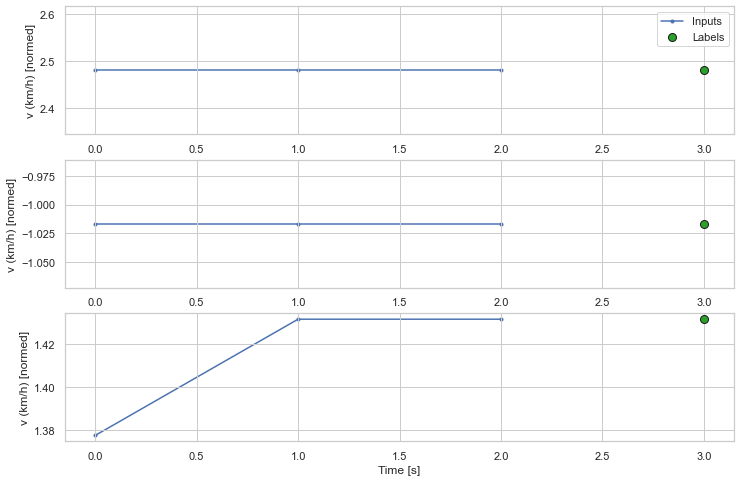

In [877]:
conv_window.plot()

In [878]:
multi_step_dense = tf.keras.Sequential([
    # Flatten shape: (time, features) => (time * features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1])])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [879]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test)

Epoch 1/20
52/52 [==============================] - 0s 5ms/step - loss: 0.2331 - mean_absolute_error: 0.2973 - val_loss: 0.0195 - val_mean_absolute_error: 0.1140
Epoch 2/20
52/52 [==============================] - 0s 3ms/step - loss: 0.0117 - mean_absolute_error: 0.0807 - val_loss: 0.0063 - val_mean_absolute_error: 0.0621
Epoch 3/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0052 - mean_absolute_error: 0.0512 - val_loss: 0.0035 - val_mean_absolute_error: 0.0477
Epoch 4/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0030 - mean_absolute_error: 0.0406 - val_loss: 0.0017 - val_mean_absolute_error: 0.0313
Epoch 5/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0292 - val_loss: 0.0010 - val_mean_absolute_error: 0.0241
Epoch 6/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0240 - val_loss: 7.1692e-04 - val_mean_absolute_error: 0.0179
Epoch 7/20
52/52 [======

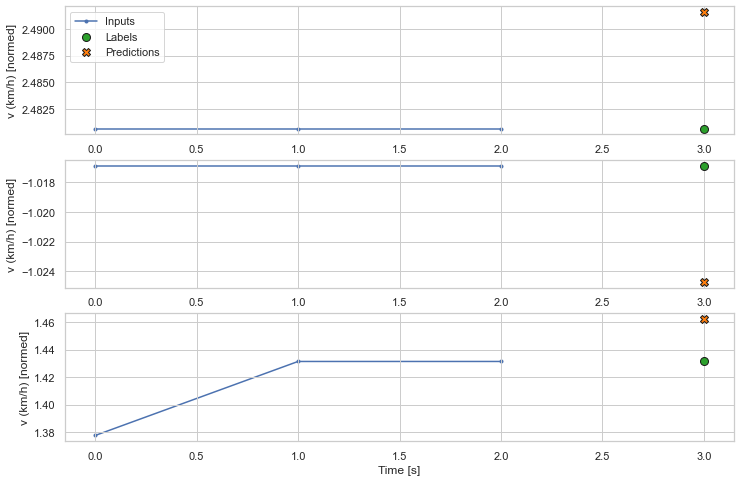

In [880]:
conv_window.plot(multi_step_dense)

#### Convolutional Neural Network

In [881]:
conv_model = tf.keras.Sequential([
    # layers.Flatten & layers.Dense => layers.Conv1D
    tf.keras.layers.Conv1D(filters=32,
                          kernel_size=(CONV_WIDTH),
                          activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [882]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test)

Epoch 1/20
52/52 [==============================] - 0s 6ms/step - loss: 0.7616 - mean_absolute_error: 0.4586 - val_loss: 0.1463 - val_mean_absolute_error: 0.2448
Epoch 2/20
52/52 [==============================] - 0s 3ms/step - loss: 0.1179 - mean_absolute_error: 0.1749 - val_loss: 0.0073 - val_mean_absolute_error: 0.0650
Epoch 3/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0071 - mean_absolute_error: 0.0539 - val_loss: 0.0025 - val_mean_absolute_error: 0.0358
Epoch 4/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0324 - val_loss: 0.0014 - val_mean_absolute_error: 0.0260
Epoch 5/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0254 - val_loss: 0.0011 - val_mean_absolute_error: 0.0209
Epoch 6/20
52/52 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0227 - val_loss: 9.3169e-04 - val_mean_absolute_error: 0.0226
Epoch 7/20
52/52 [======

In [883]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 32, 1)
Labels shape: (32, 32, 1)
Output shape: (32, 30, 1)


In [884]:
LABEL_WIDTH = 32
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['v (km/h)'])

wide_conv_window

Total window size: 35
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34]
Label column name(s): ['v (km/h)']

In [885]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 34, 1)
Labels shape: (32, 32, 1)
Output shape: (32, 32, 1)


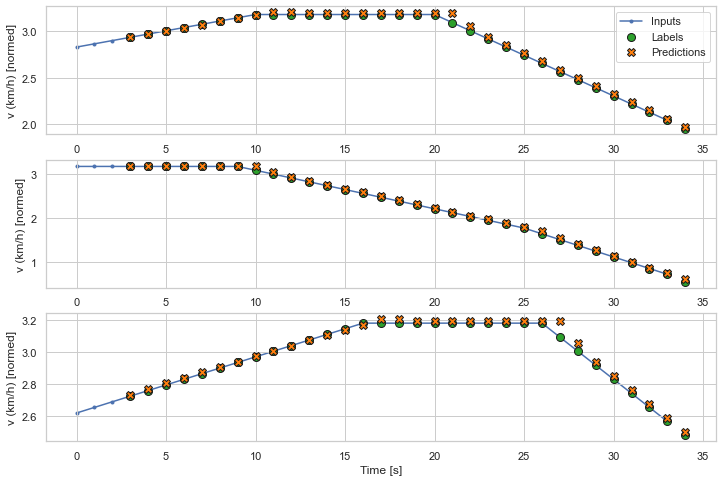

In [886]:
wide_conv_window.plot(conv_model)

#### Recurrent Neural Network

In [887]:
lstm_model = tf.keras.models.Sequential([
    # Shape: [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape: [batch, time, lstm_units] => [batch, time, features]
    tf.keras.layers.Dense(units=1)])

In [888]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 32, 1)
Output shape: (32, 32, 1)


In [889]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test)

Epoch 1/20
51/51 [==============================] - 1s 17ms/step - loss: 0.3847 - mean_absolute_error: 0.4560 - val_loss: 0.1083 - val_mean_absolute_error: 0.2533
Epoch 2/20
51/51 [==============================] - 1s 11ms/step - loss: 0.1120 - mean_absolute_error: 0.2342 - val_loss: 0.0669 - val_mean_absolute_error: 0.1900
Epoch 3/20
51/51 [==============================] - 1s 11ms/step - loss: 0.0752 - mean_absolute_error: 0.1817 - val_loss: 0.0485 - val_mean_absolute_error: 0.1529
Epoch 4/20
51/51 [==============================] - 1s 10ms/step - loss: 0.0575 - mean_absolute_error: 0.1524 - val_loss: 0.0388 - val_mean_absolute_error: 0.1362
Epoch 5/20
51/51 [==============================] - 1s 10ms/step - loss: 0.0473 - mean_absolute_error: 0.1364 - val_loss: 0.0326 - val_mean_absolute_error: 0.1215
Epoch 6/20
51/51 [==============================] - 1s 11ms/step - loss: 0.0401 - mean_absolute_error: 0.1237 - val_loss: 0.0280 - val_mean_absolute_error: 0.1113
Epoch 7/20
51/51 [====

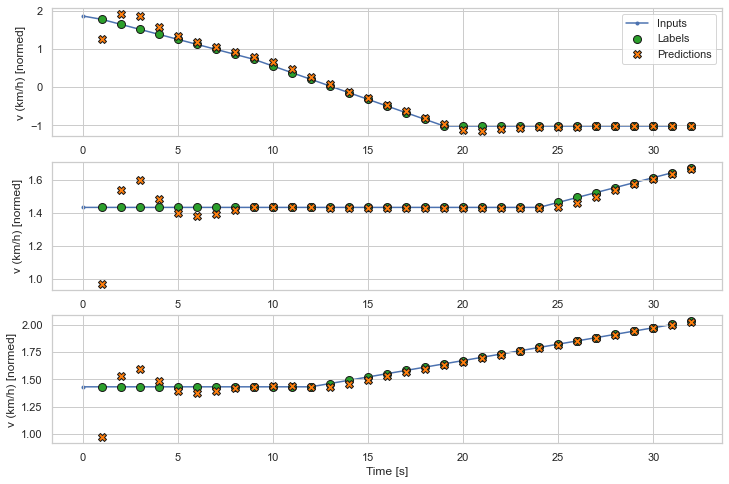

In [890]:
wide_window.plot(lstm_model)

#### Performance

In [896]:
x = np.arange(len(performance))

width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_performance, performance

({'Baseline': [0.002719313371926546, 0.030891351401805878],
  'Linear': [0.22569327056407928, 0.41344594955444336],
  'Dense': [0.002815619809553027, 0.035946764051914215],
  'Multi step dense': [0.0006719390512444079, 0.015241903252899647],
  'Conv': [0.0005996088730171323, 0.013819010928273201],
  'LSTM': [0.005311509128659964, 0.04182116314768791]},
 {'Baseline': [0.0027937819249927998, 0.0281582772731781],
  'Linear': [1.1720870733261108, 0.9877609610557556],
  'Dense': [0.002932696370407939, 0.0319741927087307],
  'Multi step dense': [0.00038793557905592024, 0.011699913069605827],
  'Conv': [0.00040759515832178295, 0.013977443799376488],
  'LSTM': [0.017412014305591583, 0.04920452833175659]})

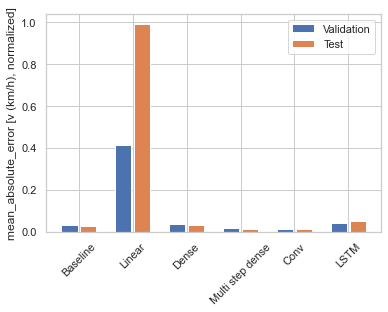

In [891]:
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [v (km/h), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()

Without the linear model

In [909]:
val_performance_without_linear = {model: v for model, v in val_performance.items()
                                 if model != 'Linear'}
performance_without_linear = {model: v for model, v in performance.items()
                              if model != 'Linear'}

val_performance_without_linear, performance_without_linear

({'Baseline': [0.002719313371926546, 0.030891351401805878],
  'Dense': [0.002815619809553027, 0.035946764051914215],
  'Multi step dense': [0.0006719390512444079, 0.015241903252899647],
  'Conv': [0.0005996088730171323, 0.013819010928273201],
  'LSTM': [0.005311509128659964, 0.04182116314768791]},
 {'Baseline': [0.0027937819249927998, 0.0281582772731781],
  'Dense': [0.002932696370407939, 0.0319741927087307],
  'Multi step dense': [0.00038793557905592024, 0.011699913069605827],
  'Conv': [0.00040759515832178295, 0.013977443799376488],
  'LSTM': [0.017412014305591583, 0.04920452833175659]})

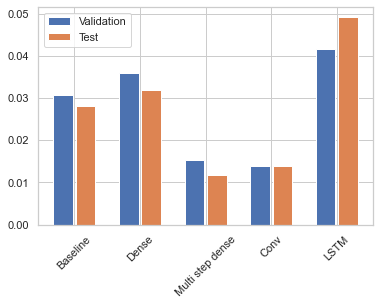

In [910]:
x = np.arange(len(performance_without_linear))

val_mae = [v[metric_index] for v in val_performance_without_linear.values()]
test_mae = [v[metric_index] for v in performance_without_linear.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance_without_linear.keys(), rotation=45)
_ = plt.legend()

In [897]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0282
Linear      : 0.9878
Dense       : 0.0320
Multi step dense: 0.0117
Conv        : 0.0140
LSTM        : 0.0492


### Multi-output models <br>
As our data contains only one output (or label), i.e., `v (km/h)`, we will skip the multi-output model

### Multi-step models <br>
Multiple time step predictions

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

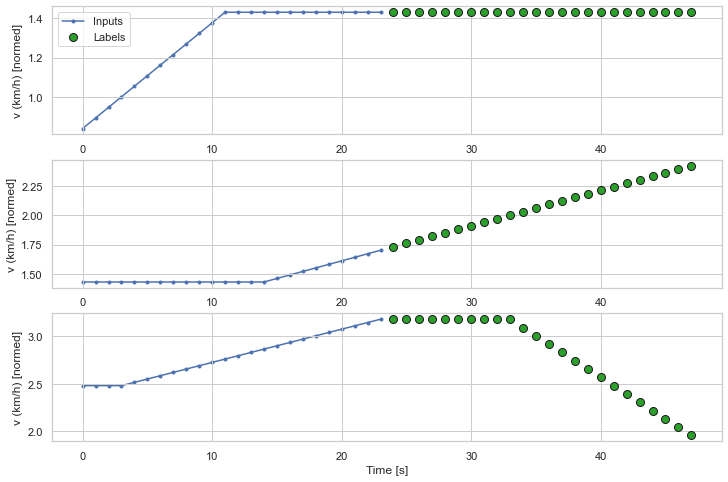

In [966]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

#### Baselines <br>
Repeat the last input time step

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 0s 501us/step - loss: 0.5259 - mean_absolute_error: 0.4044


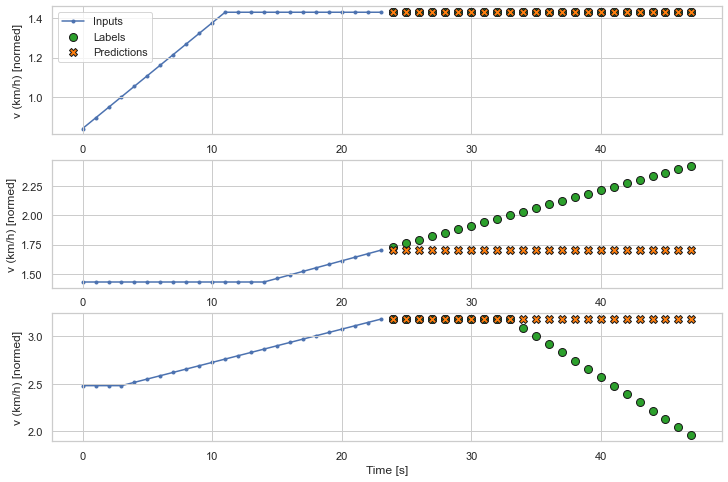

In [967]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test)

multi_window.plot(last_baseline)

Repeat the previous time window

6/6 [==============================] - 0s 501us/step - loss: 1.1311 - mean_absolute_error: 0.6754


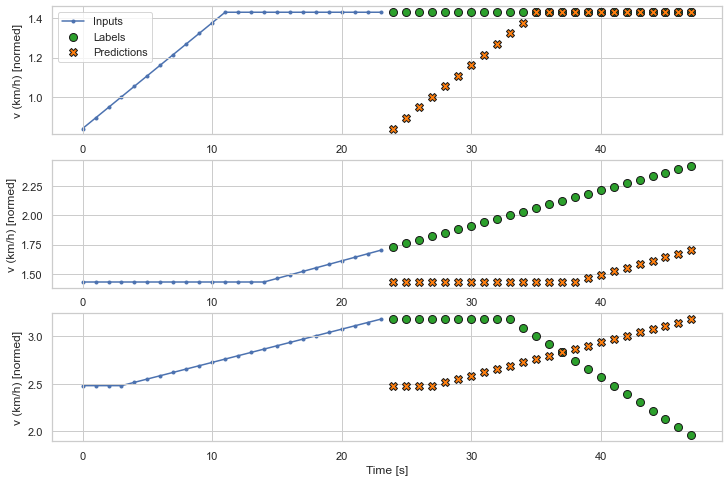

In [968]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test)

multi_window.plot(repeat_baseline)

#### Single-shot models <br>
Predict the entire sequence in a single step <br>
#### Linear

Epoch 1/20
51/51 [==============================] - 0s 3ms/step - loss: 0.9715 - mean_absolute_error: 0.7869 - val_loss: 0.6447 - val_mean_absolute_error: 0.6937
Epoch 2/20
51/51 [==============================] - 0s 1ms/step - loss: 0.8931 - mean_absolute_error: 0.7565 - val_loss: 0.5965 - val_mean_absolute_error: 0.6666
Epoch 3/20
51/51 [==============================] - 0s 1ms/step - loss: 0.8228 - mean_absolute_error: 0.7279 - val_loss: 0.5529 - val_mean_absolute_error: 0.6411
Epoch 4/20
51/51 [==============================] - 0s 1ms/step - loss: 0.7587 - mean_absolute_error: 0.7004 - val_loss: 0.5134 - val_mean_absolute_error: 0.6163
Epoch 5/20
51/51 [==============================] - 0s 1ms/step - loss: 0.7014 - mean_absolute_error: 0.6744 - val_loss: 0.4794 - val_mean_absolute_error: 0.5945
Epoch 6/20
51/51 [==============================] - 0s 1ms/step - loss: 0.6496 - mean_absolute_error: 0.6497 - val_loss: 0.4483 - val_mean_absolute_error: 0.5731
Epoch 7/20
51/51 [==========

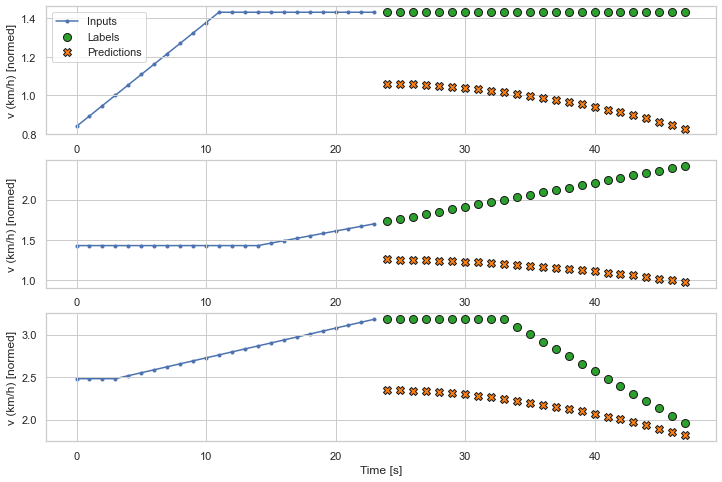

In [969]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape: [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Output layer
    # Shape => [batch, 1, out_steps * features]
    tf.keras.layers.Dense(OUT_STEPS * num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test)

multi_window.plot(multi_linear_model)

#### Dense

Epoch 1/20
51/51 [==============================] - 0s 3ms/step - loss: 0.5192 - mean_absolute_error: 0.5468 - val_loss: 0.2486 - val_mean_absolute_error: 0.3734
Epoch 2/20
51/51 [==============================] - 0s 2ms/step - loss: 0.2564 - mean_absolute_error: 0.3884 - val_loss: 0.2375 - val_mean_absolute_error: 0.3835
Epoch 3/20
51/51 [==============================] - 0s 2ms/step - loss: 0.2496 - mean_absolute_error: 0.3860 - val_loss: 0.2323 - val_mean_absolute_error: 0.3776
Epoch 4/20
51/51 [==============================] - 0s 2ms/step - loss: 0.2441 - mean_absolute_error: 0.3782 - val_loss: 0.2264 - val_mean_absolute_error: 0.3667
Epoch 5/20
51/51 [==============================] - 0s 2ms/step - loss: 0.2411 - mean_absolute_error: 0.3725 - val_loss: 0.2257 - val_mean_absolute_error: 0.3655
Epoch 6/20
51/51 [==============================] - 0s 2ms/step - loss: 0.2408 - mean_absolute_error: 0.3706 - val_loss: 0.2244 - val_mean_absolute_error: 0.3649
Epoch 7/20
51/51 [==========

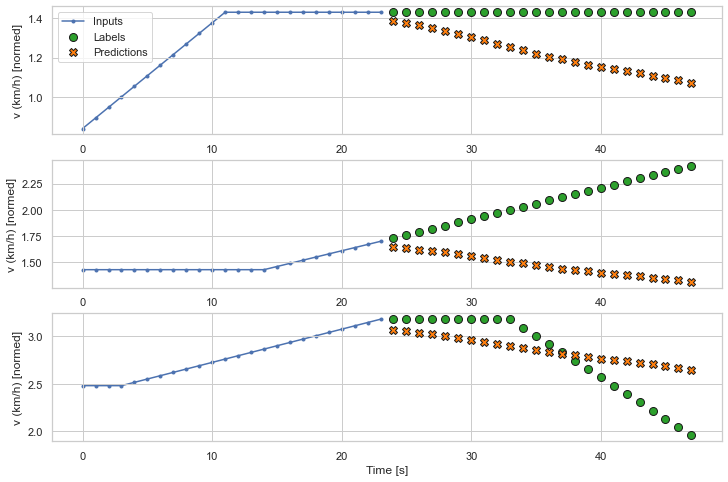

In [970]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Hidden layer
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Output layer
    # Shape => [batch, out_steps * features]
    tf.keras.layers.Dense(OUT_STEPS * num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test)

multi_window.plot(multi_dense_model)

#### CNN

Epoch 1/20
51/51 [==============================] - 0s 3ms/step - loss: 0.5656 - mean_absolute_error: 0.5765 - val_loss: 0.2615 - val_mean_absolute_error: 0.3904
Epoch 2/20
51/51 [==============================] - 0s 2ms/step - loss: 0.2803 - mean_absolute_error: 0.4072 - val_loss: 0.2484 - val_mean_absolute_error: 0.4009
Epoch 3/20
51/51 [==============================] - 0s 2ms/step - loss: 0.2622 - mean_absolute_error: 0.4005 - val_loss: 0.2400 - val_mean_absolute_error: 0.3930
Epoch 4/20
51/51 [==============================] - 0s 2ms/step - loss: 0.2528 - mean_absolute_error: 0.3913 - val_loss: 0.2329 - val_mean_absolute_error: 0.3854
Epoch 5/20
51/51 [==============================] - 0s 2ms/step - loss: 0.2462 - mean_absolute_error: 0.3855 - val_loss: 0.2284 - val_mean_absolute_error: 0.3809
Epoch 6/20
51/51 [==============================] - 0s 2ms/step - loss: 0.2378 - mean_absolute_error: 0.3746 - val_loss: 0.2263 - val_mean_absolute_error: 0.3760
Epoch 7/20
51/51 [==========

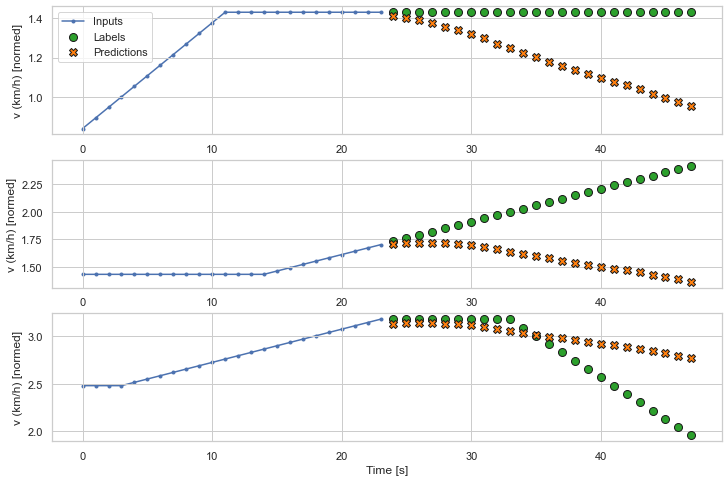

In [971]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Conv layer
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Output layer
    # Shape => [batch, 1, out_steps * features]
    tf.keras.layers.Dense(OUT_STEPS * num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test)

multi_window.plot(multi_conv_model)

#### RNN

Epoch 1/20
51/51 [==============================] - 1s 15ms/step - loss: 0.7833 - mean_absolute_error: 0.7109 - val_loss: 0.3762 - val_mean_absolute_error: 0.5177
Epoch 2/20
51/51 [==============================] - 0s 8ms/step - loss: 0.4078 - mean_absolute_error: 0.5247 - val_loss: 0.3158 - val_mean_absolute_error: 0.4601
Epoch 3/20
51/51 [==============================] - 0s 8ms/step - loss: 0.3291 - mean_absolute_error: 0.4674 - val_loss: 0.2925 - val_mean_absolute_error: 0.4450
Epoch 4/20
51/51 [==============================] - 0s 8ms/step - loss: 0.3000 - mean_absolute_error: 0.4446 - val_loss: 0.2780 - val_mean_absolute_error: 0.4292
Epoch 5/20
51/51 [==============================] - 0s 8ms/step - loss: 0.2644 - mean_absolute_error: 0.4185 - val_loss: 0.2705 - val_mean_absolute_error: 0.4204
Epoch 6/20
51/51 [==============================] - 0s 8ms/step - loss: 0.2345 - mean_absolute_error: 0.3930 - val_loss: 0.2464 - val_mean_absolute_error: 0.3973
Epoch 7/20
51/51 [=========

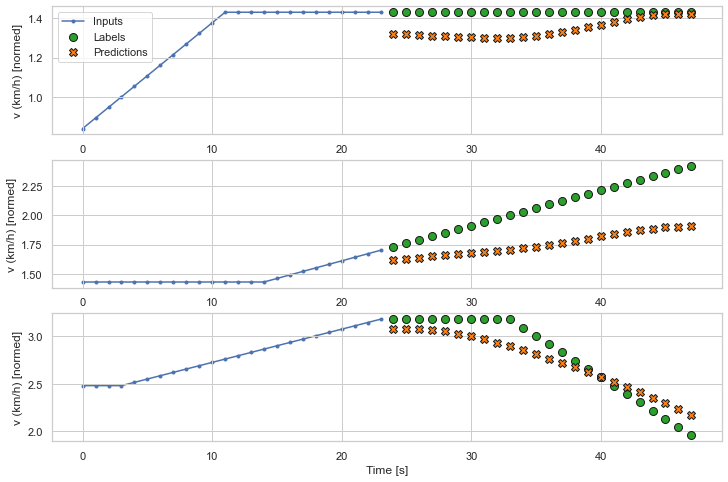

In [972]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps * features]
    tf.keras.layers.Dense(OUT_STEPS * num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test)

multi_window.plot(multi_lstm_model)

#### Autoregressive model

In [973]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
    # Init internal state based on the inputs
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)
        # prediction.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
        
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

In [974]:
def call(self, inputs, training=None):
    predictions = []
    # Initialize the LSTM state
    prediction, state = self.warmup(inputs)
    # Insert the first prediction
    predictions.append(prediction)
    
    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one LSTM step.
        x, state = self.lstm_cell(x, states=state, training=training)
        # Convert the LSTM output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)
        
    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [975]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 1)


Epoch 1/20
51/51 [==============================] - 1s 19ms/step - loss: 0.5945 - mean_absolute_error: 0.6124 - val_loss: 0.3525 - val_mean_absolute_error: 0.4854
Epoch 2/20
51/51 [==============================] - 1s 10ms/step - loss: 0.3213 - mean_absolute_error: 0.4566 - val_loss: 0.2444 - val_mean_absolute_error: 0.4083
Epoch 3/20
51/51 [==============================] - 0s 10ms/step - loss: 0.2338 - mean_absolute_error: 0.3639 - val_loss: 0.1365 - val_mean_absolute_error: 0.2871
Epoch 4/20
51/51 [==============================] - 1s 10ms/step - loss: 0.1896 - mean_absolute_error: 0.3128 - val_loss: 0.1248 - val_mean_absolute_error: 0.2693
Epoch 5/20
51/51 [==============================] - 0s 10ms/step - loss: 0.1730 - mean_absolute_error: 0.3018 - val_loss: 0.1383 - val_mean_absolute_error: 0.2802
Epoch 6/20
6/6 [==============================] - 0s 2ms/step - loss: 0.1995 - mean_absolute_error: 0.3339


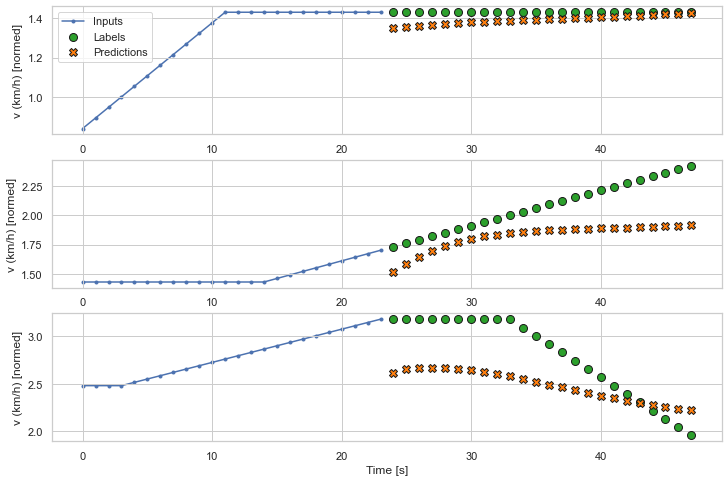

In [976]:
history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test)

multi_window.plot(feedback_model)

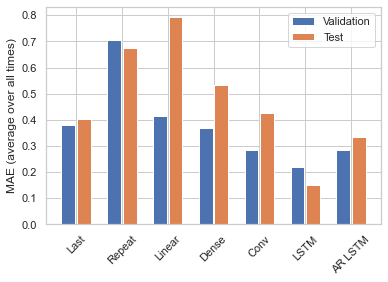

In [977]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f'MAE (average over all times)')
_ = plt.legend()

In [978]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.4044
Repeat  : 0.6754
Linear  : 0.7917
Dense   : 0.5319
Conv    : 0.4266
LSTM    : 0.1508
AR LSTM : 0.3339
